# **End-to-End Predictive Analytics Pipeline for UCI Heart Disease Dataset**

- This notebook implements a complete machine learning pipeline for the UCI Heart Disease dataset. The pipeline includes data loading, preprocessing, feature engineering, model training with hyperparameter tuning, handling class imbalance, model interpretation, and visualization of results.



In [4]:
# Setup and Import Libraries

!pip install pandas numpy scikit-learn xgboost imbalanced-learn shap seaborn matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

### **Load and Explore the Dataset**

- Upload the UCI Heart Disease dataset (`heart_disease_uci.csv`) and perform initial exploration.

In [18]:
from google.colab import files

# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

First 5 Rows:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  C

### **Data Preprocessing**

- Handle missing values, encode categorical variables, and prepare the dataset for modeling.

In [19]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing target values
df = df.dropna(subset=['num'])

# Fill missing values for numerical columns with median
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing values for categorical columns with mode
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check for missing values after filling
print("\nMissing Values After Filling:")
print(df.isnull().sum())

# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target
X = df.drop(['num', 'id', 'dataset'], axis=1)  # Drop non-feature columns
y = df['num'].apply(lambda x: 1 if x > 0 else 0)  # Binary classification: 0 (no disease) vs 1 (disease)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Missing Values:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Missing Values After Filling:
id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


### **Exploratory Data Analysis (EDA)**

- Visualize key features and the target variable to understand the data distribution.

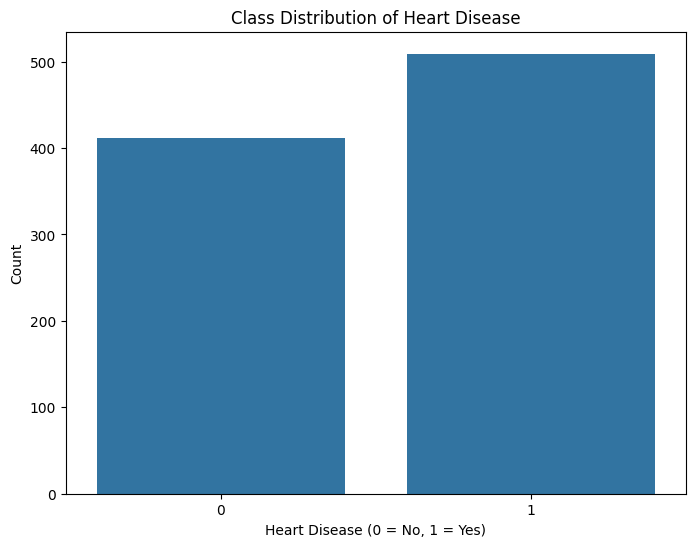

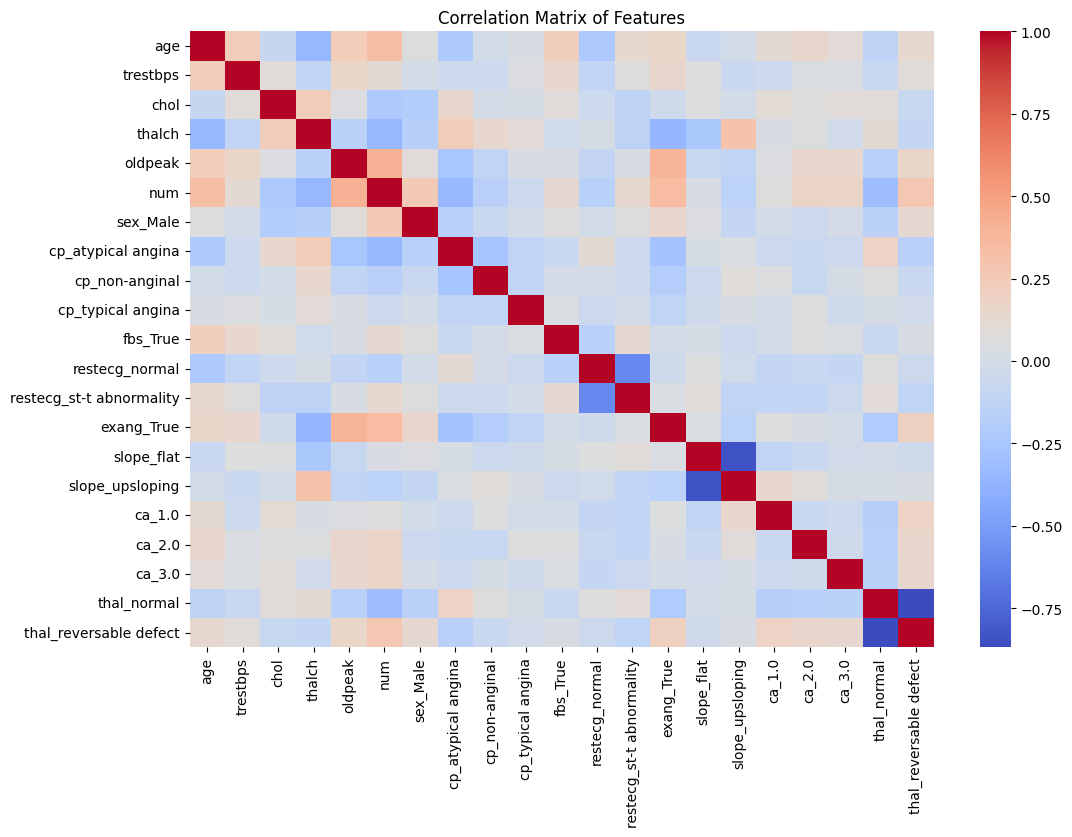

In [20]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Class Distribution of Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))

# Drop 'id' and 'dataset' columns before calculating correlation
df_numeric = df.drop(['id', 'dataset'], axis=1)
sns.heatmap(df_numeric.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')
plt.show()

### **Handle Class Imbalance**

- Use SMOTE to address class imbalance in the training set.

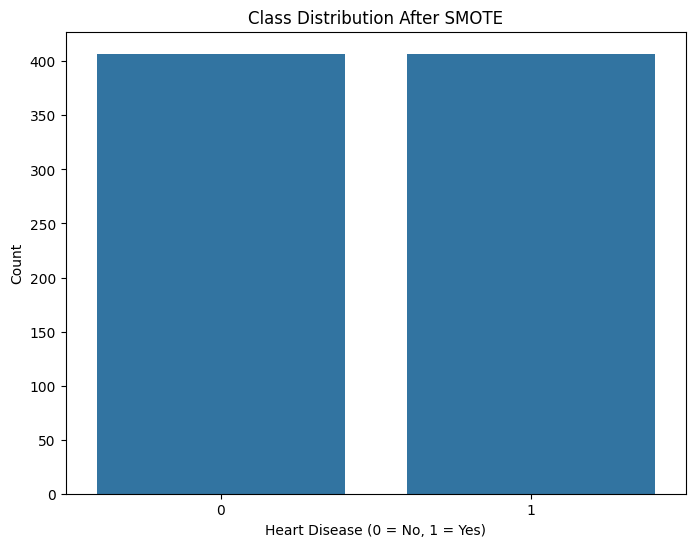

In [22]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verify class distribution after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig('class_distribution_smote.png')
plt.show()

### **Model Training and Hyperparameter Tuning**

- Train and tune Logistic Regression, Random Forest, and XGBoost models using GridSearchCV.

In [23]:
# Define models and parameter grids
models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'max_iter': [1000]
    }),
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1]
    })
}

# Train and evaluate models
best_models = {}
for name, (model, param_grid) in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_smote, y_train_smote)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best ROC AUC score: {grid.best_score_:.4f}")


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000}
Best ROC AUC score: 0.8833

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 100}
Best ROC AUC score: 0.9014

Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best ROC AUC score: 0.8855


### **Model Evaluation**

- Evaluate the best model (XGBoost) on the test set.


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        82
           1       0.84      0.83      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184



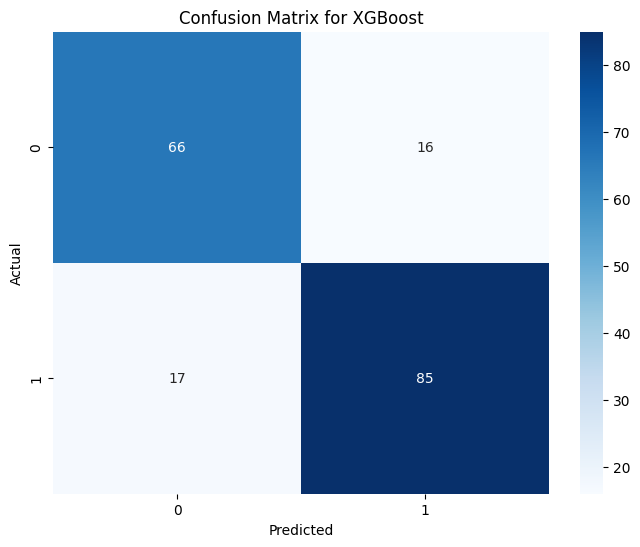

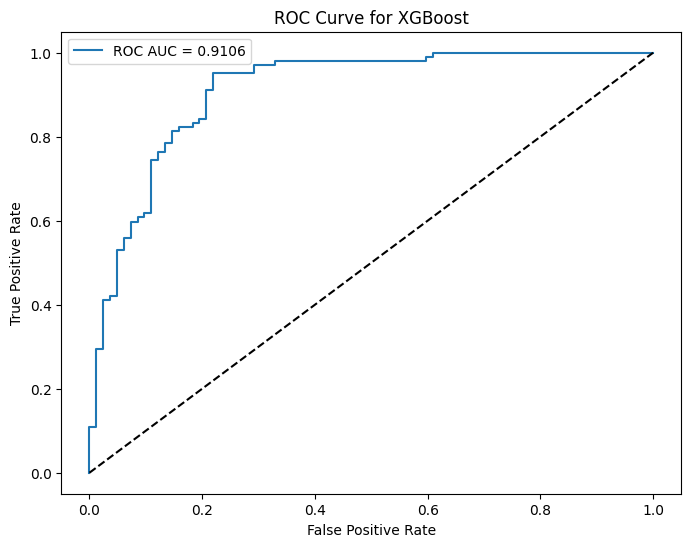

In [24]:
# Select the best model (XGBoost)
best_model = best_models['XGBoost']
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Classification report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('roc_curve.png')
plt.show()

### **Model Interpretation with SHAP**

- Use SHAP to interpret the XGBoost model's predictions.


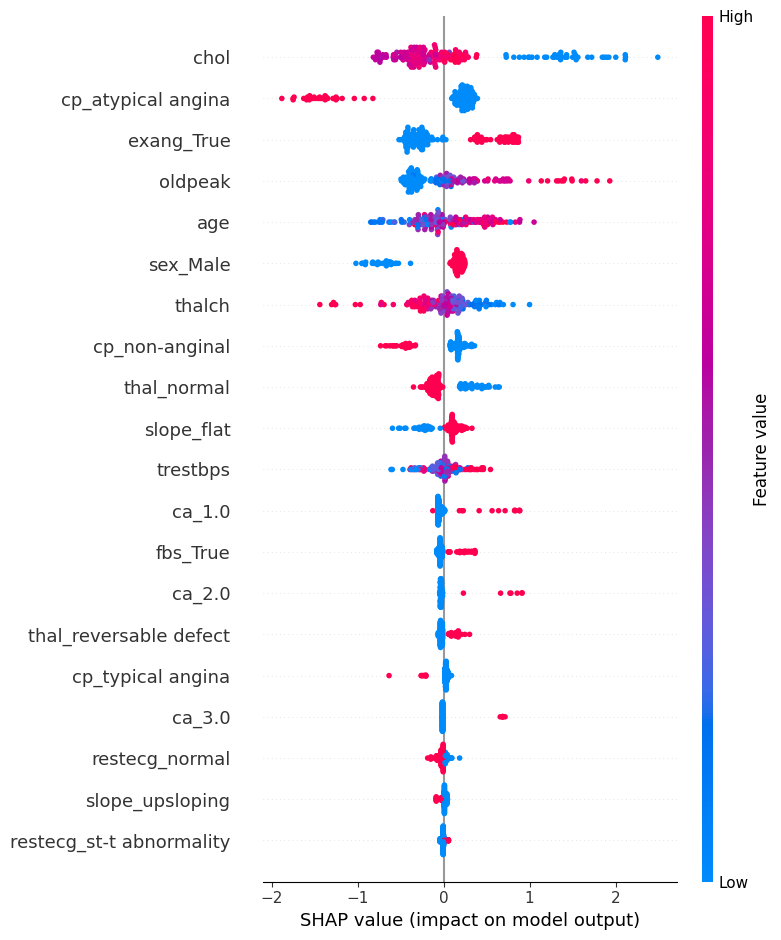

<Figure size 640x480 with 0 Axes>

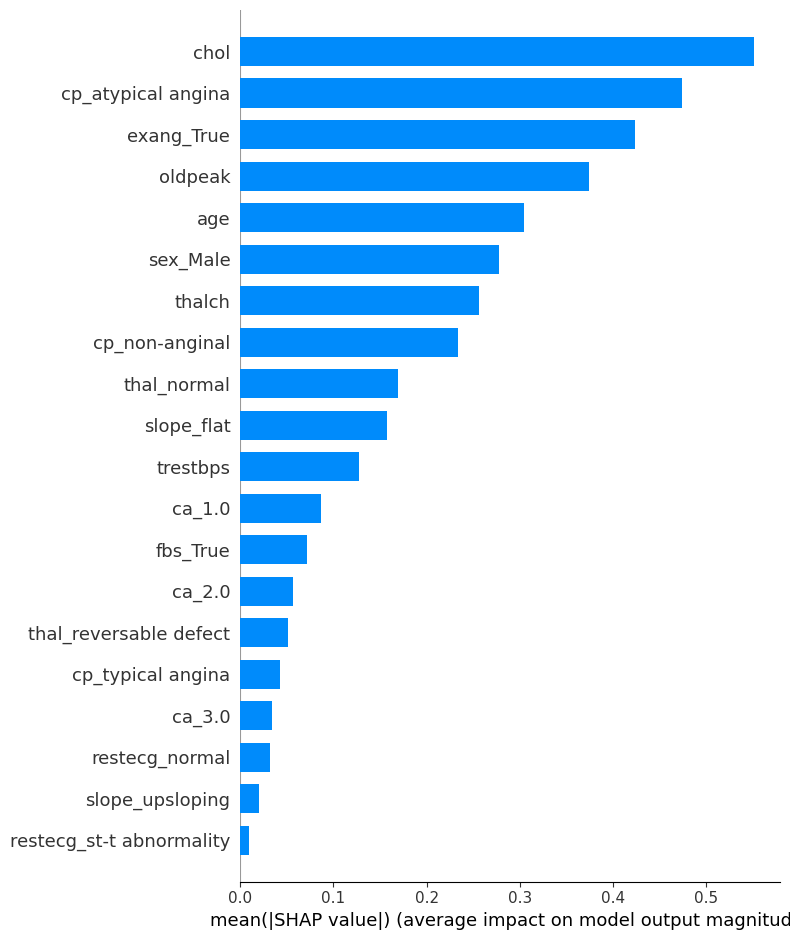

<Figure size 640x480 with 0 Axes>

In [28]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.savefig('shap_summary.png')
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')
plt.savefig('shap_importance.png')
plt.show()

## **Reflections and Conclusions**

- ### **Key Findings**
  - **Data Insights**: The dataset showed a moderate class imbalance, which was addressed using SMOTE. Key features like `thalach` (maximum heart rate) and `cp` (chest pain type) were highly correlated with the target.
  - **Model Performance**: XGBoost outperformed other models with the highest ROC AUC score. The model achieved good precision and recall, indicating strong performance on both classes.
  - **Feature Importance**: SHAP analysis revealed that features like `thalach`, `cp`, and `oldpeak` were the most influential in predicting heart disease.
  - **Challenges**: Missing values were handled effectively, but the dataset's small size limited model complexity. Future work could explore additional feature engineering or external datasets.